In [2]:
import numpy as np
import matplotlib.pyplot as plt
import glob 
import torch
import torch.nn as nn
import torch.optim as optim 
import time 

In [3]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device 

device(type='cuda')

In [4]:
dir_eating="/home/olagh48652/smart-home/src/smart-home/external/activity_zed/segmented/eating/"
dir_noneating="/home/olagh48652/smart-home/src/smart-home/external/activity_zed/segmented/noneating/"

In [5]:
fn_eating=glob.glob(dir_eating+"*")
fn_noneating=glob.glob(dir_noneating+"*")
len(fn_eating), len(fn_noneating)

(16, 29)

In [6]:
eating_data=[]
noneating_data=[]
for fn in fn_eating:
    data=np.loadtxt(fn, delimiter=',')
    eating_data.append(data)

for fn in fn_noneating:
    data=np.loadtxt(fn, delimiter=',')
    noneating_data.append(data)

eating_data=np.array(eating_data)
noneating_data=np.array(noneating_data)

eating_data.shape, noneating_data.shape

((16, 300, 50), (29, 300, 50))

In [7]:
X=np.concatenate((eating_data, noneating_data))
X.shape

(45, 300, 50)

In [8]:
y=np.array([1]*eating_data.shape[0]+[0]*noneating_data.shape[0])
y.shape

(45,)

In [9]:
X=torch.from_numpy(X).float()
y=torch.from_numpy(y).reshape(-1,1)
X.shape, y.shape

(torch.Size([45, 300, 50]), torch.Size([45, 1]))

In [10]:
ids=np.arange(X.shape[0])
np.random.shuffle(ids)
train_ids=ids[:int(len(ids)*0.8)]
test_ids=ids[int(len(ids)*0.8):]
X_train, y_train=X[train_ids], y[train_ids]
X_test, y_test=X[test_ids], y[test_ids]

X_train.shape, y_train.shape, X_test.shape, y_test.shape

(torch.Size([36, 300, 50]),
 torch.Size([36, 1]),
 torch.Size([9, 300, 50]),
 torch.Size([9, 1]))

In [11]:
class LSTM(nn.Module):
    
    def __init__(self,input_dim,hidden_dim,output_dim,layer_num, seq_len):
        super(LSTM,self).__init__()
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.lstm = torch.nn.LSTM(input_dim,hidden_dim,layer_num,batch_first=True)
        self.fc = torch.nn.Linear(hidden_dim,output_dim)
        self.bn = nn.BatchNorm1d(seq_len)
        
    def forward(self,inputs):
        x = self.bn(inputs)
        lstm_out,(hn,cn) = self.lstm(x)
        out = self.fc(lstm_out[:,-1,:])
        return out

In [12]:
import random
n_data_size_train = X_train.shape[0]
n_data_size_test = X_test.shape[0]

def randomTrainingExampleBatch(batch_size,flag,num=-1):
    if flag == 'train':
        X = X_train
        y = y_train
        data_size = n_data_size_train
    elif flag == 'test':
        X = X_test
        y = y_test
        data_size = n_data_size_test
    if num == -1:
        ran_num = random.randint(0,data_size-batch_size)
    else:
        ran_num = num
    pose_sequence_tensor = X[ran_num:(ran_num+batch_size)]
    pose_sequence_tensor = pose_sequence_tensor
    category_tensor = y[ran_num:ran_num+batch_size,:]
    return category_tensor.long(),pose_sequence_tensor

In [13]:
n_hidden = 128
n_joints = 25*2
n_categories = 2
n_layer = 3
seq_len = 300
rnn = LSTM(n_joints,n_hidden,n_categories,n_layer, seq_len)
rnn.to(device)

LSTM(
  (lstm): LSTM(50, 128, num_layers=3, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
  (bn): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [14]:
criterion = nn.CrossEntropyLoss()
learning_rate = 0.0005
optimizer = optim.SGD(rnn.parameters(),lr=learning_rate,momentum=0.9)

In [15]:
n_iters = 10_000
print_every = 1000
plot_every = 1000
batch_size = 4

current_loss = 0
all_losses = []

 
start = time.time()

for iter in range(1, n_iters + 1):
   
    category_tensor, input_sequence = randomTrainingExampleBatch(batch_size,'train')
    input_sequence = input_sequence.to(device)
    category_tensor = category_tensor.to(device)
    category_tensor = torch.squeeze(category_tensor)
    
    optimizer.zero_grad()
    
    output = rnn(input_sequence)
    loss = criterion(output, category_tensor)
    loss.backward()
    optimizer.step() 
 
    current_loss += loss.item()

    if iter % print_every == 0:
        print('iter: %d, loss: %.3f' % (iter, loss.item()))
    
    
    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

iter: 1000, loss: 0.681
iter: 2000, loss: 0.374
iter: 3000, loss: 0.018
iter: 4000, loss: 0.005
iter: 5000, loss: 0.005
iter: 6000, loss: 0.003
iter: 7000, loss: 0.002
iter: 8000, loss: 0.003
iter: 9000, loss: 0.001
iter: 10000, loss: 0.002


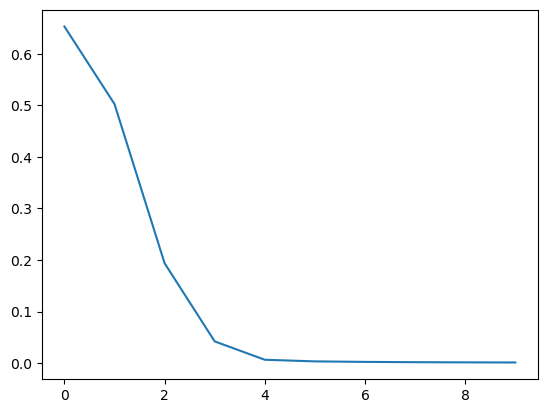

In [16]:
plt.plot(all_losses)

In [17]:
#test 

rnn.eval()

n_correct = 0
n_total = 0
for i in range(n_data_size_test):
    category_tensor, input_sequence = randomTrainingExampleBatch(1,'test',i)
    input_sequence = input_sequence.to(device)
    category_tensor = category_tensor.to(device)
    category_tensor = torch.squeeze(category_tensor)
    output = rnn(input_sequence)
    po=output.argmax(axis=1)
    guess=po.item()
    category = category_tensor
    if category == guess:
        n_correct += 1
    n_total += 1

print('Accuracy of %d test data: %.3f%%' % (n_data_size_test, n_correct / n_total * 100))

Accuracy of 9 test data: 77.778%


In [18]:
#test 
n_correct = 0
n_total = 0
for i in range(n_data_size_test):
    category_tensor, input_sequence = randomTrainingExampleBatch(1,'train',i)
    input_sequence = input_sequence.to(device)
    category_tensor = category_tensor.to(device)
    category_tensor = torch.squeeze(category_tensor)
    output = rnn(input_sequence)
    po=output.argmax(axis=1)
    guess=po.item()
    category = category_tensor
    if category == guess:
        n_correct += 1
    n_total += 1

print('Accuracy of %d test data: %.3f%%' % (n_data_size_test, n_correct / n_total * 100))

Accuracy of 9 test data: 100.000%


In [18]:
#save model
torch.save(rnn.state_dict(), "lstm_zed_april17_new.pth")